In [1]:
import os

# Restrict PyTorch to only see GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch

if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available, using CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Number of GPUs available: 1
GPU 0: NVIDIA L40S
Using device: cuda:0


In [2]:
from spatialvla.datasets import RLDSBatchTransform, RLDSDataset

2024-12-10 16:21:23.007851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 16:21:23.037223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 16:21:23.037269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 16:21:23.038149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 16:21:23.043368: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from spatialvla.mobilevlm.model.mobilevlm import load_pretrained_vlm_for_vla, load_vla
from scripts.spatialvla_config import ModelArguments, TrainingArguments
import transformers

model_args = ModelArguments()

# tokenizer, model, image_processor, _ = load_pretrained_vlm_for_vla(
#     model_args,
#     load_8bit=False, 
#     load_4bit=False,
#     device='cuda',
# )
tokenizer, model, image_processor, _ = load_vla('/home/jellyho/Bimanual_Imitation/MobileVLM-VLA/checkpoints/libero_object_octo_full')

[2024-12-10 16:21:28,629] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/jellyho/miniconda3/envs/mobilevlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32000. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [4]:
## RLDS Dataset loading
batch_transform = RLDSBatchTransform(
        tokenizer,
        image_processor,
    )
# Init complete

In [5]:
cfg = TrainingArguments()

In [6]:
vla_dataset = RLDSDataset(
        data_root_dir='/home/shared/rlds_datasets',
        data_mix='libero_object_no_noops',
        batch_transform=batch_transform,
        shuffle_buffer_size=100,
        window_size=1,
        future_action_window_size=0,
        use_state_input = True
    )

{'name': 'libero_object_no_noops', 'data_dir': '/home/shared/rlds_datasets', 'image_obs_keys': {'primary': 'image'}, 'state_obs_keys': ['EEF_state', 'gripper_state'], 'absolute_action_mask': [False, False, False, False, False, False, True], 'action_normalization_mask': [True, True, True, True, True, True, False], 'action_proprio_normalization_type': <NormalizationType.NORMAL: 'normal'>, 'language_key': 'language_instruction', 'standardize_fn': <function libero_dataset_transform at 0x14cafdb4e950>}


2024-12-10 16:21:49.883396: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


['EEF_state', 'gripper_state']
Computing dataset statistics. This may take a bit, but should only need to happen once.


100%|█████████████████████████████████████████████████████████████| 454/454 [00:01<00:00, 434.92it/s]
2024-12-10 16:21:51.639538: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


['EEF_state', 'gripper_state']

######################################################################################
# Loading the following 1 datasets (incl. sampling weight):                         #
# libero_object_no_noops: ==================================================1.000000 #
######################################################################################

Threads per Dataset:  [1]
Reads per Dataset:  [1]
Constructing datasets...
['EEF_state', 'gripper_state']


2024-12-10 16:21:52.414935: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Applying frame transforms on dataset...


In [7]:
ds = next(vla_dataset.dataset.as_numpy_iterator())

In [8]:
ds['observation']['proprio']

array([[ 1.2856674 , -0.5281119 , -0.03057644, -0.02492936,  0.22816351,
         0.82396233,  1.0740354 , -0.9965183 ]], dtype=float32)

(1, 256, 256, 3)


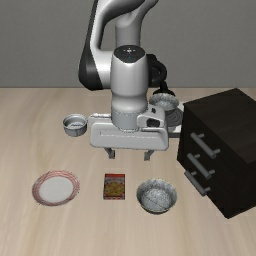

In [35]:
from PIL import Image
print(ds['observation']['image_primary'].shape)
img = Image.fromarray(ds['observation']['image_primary'][0])
display(img)

In [9]:
from spatialvla.datasets.rlds.utils.data_utils import PaddedCollatorForActionPrediction

collator = PaddedCollatorForActionPrediction(tokenizer.model_max_length, tokenizer.pad_token_id, padding_side='right')

In [10]:

from torch.utils.data import DataLoader
dataloader = DataLoader(
        vla_dataset,
        batch_size=1,
        sampler=None,
        collate_fn=collator,
        num_workers=0,  # Important =>> Set to 0 if using RLDS; TFDS rolls its own parallelism!
    )

In [32]:
import torch
device_id = 0
for batch in dataloader:
    with torch.autocast('cuda', dtype=torch.float16):
        action = model.forward(
            input_ids=batch['input_ids'].to(device_id),
            images=batch['pixel_values'].to(device_id),
            attention_mask=batch['attention_mask'].to(device_id)
        )
    break

In [39]:
action

tensor([[[-1.3660e-01, -5.4901e-02,  4.0088e-01, -7.2876e-02, -1.6003e-01,
          -1.0967e-03,  3.6836e+00]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<ReshapeAliasBackward0>)

In [40]:
batch.keys()                                 

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'action', 'dataset_names'])

In [41]:
batch['action']

tensor([[[-0.2159, -0.0620,  1.9062, -1.8682, -1.6836, -1.3896,  4.0000]]],
       dtype=torch.float16)

In [42]:
((action.cpu() - batch['action']) ** 2).sum()

tensor(9.8438, dtype=torch.float16, grad_fn=<SumBackward0>)